In [1]:
# Mount Drive to Access Data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Authenticate to access cloud bucket
from google.colab import auth
auth.authenticate_user()

# # # #create a LOCAL directory in /content/  so you can move stuff from bucket to local
!mkdir /content/w281FinalProjectLogo
!mkdir /content/w281FinalProjectLogo/Logos-32plus_v1.0.1
# #copy from google bucket to local directory
!gsutil -m -q cp -r gs://w281finalprojectlogo/Logos-32plus_v1.0.1 /content/w281FinalProjectLogo

### Import Libraries and Set Paths

In [5]:
# # Define directories
# base_dir = '/content/drive/MyDrive/w281FinalProjectLogo/'
# model_dir = base_dir + '/john/manual_model/'
# fe_dir = base_dir + 'Logos-32plus_v1.0.1/feature_extraction/'
# bb_path = base_dir + 'Logos-32plus_v1.0.1/preprocessed/bb/'
# cn_path = base_dir + 'Logos-32plus_v1.0.1/preprocessed/cn/'
# base_dir = '/content/drive/MyDrive/w281FinalProjectLogo/'
# drive_save_dir = base_dir + 'Logos-32plus_v1.0.1/feature_extraction/'
# john_dir = base_dir + '/john/'


# Define directories
base_dir = '/content/drive/MyDrive/w281FinalProjectLogo/'
bucket = '/content/w281FinalProjectLogo/Logos-32plus_v1.0.1/'
john_dir = base_dir + '/john/'
fe_dir = base_dir + '/john/feature_extraction/'
model_dir = base_dir + '/john/manual_model/'
drive_save_dir = base_dir + 'Logos-32plus_v1.0.1/feature_extraction/'

# reading, writing to bucket
preproc_dir = bucket + 'preprocessed/'
bucket_save_dir = bucket + 'feature_extraction/'
da_path = preproc_dir + 'da/'
bb_path = preproc_dir + 'bb/'
cn_path = preproc_dir + 'cn/'

In [6]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix, \
      roc_auc_score, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.decomposition import PCA
import seaborn as sns

sys.path.append(model_dir)
from eval_fns import roc_ovr_all, visualize_errors

### Load Data, Split

In [17]:
# Load df with extracted features
df = pd.read_pickle(drive_save_dir + 'fe_merged_112722.csv')
df.dropna(subset=['norm_hist'], inplace=True)
print(f"Num Bboxes: {len(df)}")
print(df['split'].value_counts())

Num Bboxes: 11056
train    10696
val        360
Name: split, dtype: int64


In [18]:
# Prepare class mapping for preds
class_map= { 0 : 'adidas', 1 : 'dhl', 2 : 'apple', 3 : 'bmw', 4 : 'cocacola', 5 : 'fedex', 6 : 'heineken', 7 : 'pepsi', 8 : 'starbucks', 9 : 'ups'}
df.sort_values('class_code', ascending=True, inplace=True)
class_names = df['class'].unique()

In [19]:
## Select features to use in modeling
# Section 1: Non-SIFT features
ns_features = ['cm_hsv_mean', 'cm_hsv_var', 'cm_hsv_skew',
                'cm_rgb_mean', 'cm_rgb_var', 'cm_rgb_skew',
                'cm_ycrcb_mean','cm_ycrcb_var', 'cm_ycrcb_skew',
                'hu_moments', 'contrast', 'dissimilarity',
                'homogeneity', 'energy', 'correlation', 'ASM']
                
# Non-SIFT: Combine each feature vector into 1-D array
features_ns = []
for idx, row in df.iterrows():
  vals = []
  for col in ns_features:
    vals.extend(list(row[col]))
  features_ns.append(vals)
df['features_ns'] = features_ns


# Section 2: All Features
all_features = ns_features + ['norm_hist']
                
# Combine each feature vector into 1-D array
features_all = []
for idx, row in df.iterrows():
  vals = []
  for col in all_features:
    vals.extend(list(row[col]))
  features_all.append(vals)
df['features_all'] = features_all

In [20]:
## split df
train_df = df.loc[df['split']=='train', ].copy()
val_df = df.loc[df['split']=='val', ].copy()
test_df = df.loc[df['split']=='test', ].copy()

## split X, y
y_train = train_df['class_code'].values
y_val = val_df['class_code'].values
y_test = test_df['class_code'].values

# Section 1: Non-SIFT features
X_train_ns = train_df['features_ns'].tolist()
X_val_ns = val_df['features_ns'].tolist()
X_test_ns = test_df['features_ns'].tolist()

# Section 2: All Features
X_train_all = train_df['features_all'].tolist()
X_val_all = val_df['features_all'].tolist()
X_test_all = test_df['features_all'].tolist()

In [21]:
## Standardize inputs
# Section 1: Non-SIFT features
scaler = StandardScaler() 
X_train_scaled_ns = scaler.fit_transform(X_train_ns)
X_val_scaled_ns = scaler.transform(X_val_ns)
#X_test_scaled_ns = scaler.transform(X_test_ns) <- waiting for SIFT Test set

# Section 2: All Features
scaler = StandardScaler() 
X_train_scaled_all = scaler.fit_transform(X_train_all)
X_val_scaled_all = scaler.transform(X_val_all)
#X_test_scaled_all = scaler.transform(X_test_all) <- waiting for SIFT Test set

In [22]:
# ## PCA of all features
# pca = PCA(n_components=10)
# pca.fit(X_train_scaled)
# X_train_scaled_pca = pca.transform(X_train_scaled)
# #X_val_scaled_pca = pca.transform(X_val_scaled)
# #X_test_scaled_pca = pca.transform(X_test_scaled)

# Section 1: Non-SIFT Feature Modeling

## Model 1.1: SVM

In [28]:
# Instantiate linear SVC
lsvc = LinearSVC(penalty='l2', dual=False, multi_class = 'ovr', max_iter = 5000,
                 C = 0.22, class_weight='balanced')

# Fit the training histograms and predict with SVC on training data itself
lsvc.fit(X_train_scaled_ns, y_train)

# Generate preds
lsvc_preds = lsvc.predict(X_val_scaled_ns)
val_df['lsvc_pred'] = lsvc_preds
val_df['pred_name'] = val_df["lsvc_pred"].replace(class_map)

# Get accuracy
acc = accuracy_score(y_val, lsvc_preds)
print(f"Accuracy: {acc:.2%}\n")

Accuracy: 75.28%



In [29]:
# Classification Report
print(classification_report(y_val, lsvc_preds, target_names=class_names))

              precision    recall  f1-score   support

      adidas       0.62      0.41      0.49        32
         dhl       0.85      0.94      0.89        35
       apple       0.59      0.68      0.63        25
         bmw       0.64      0.67      0.65        27
    cocacola       0.86      0.68      0.76        28
       fedex       0.88      0.89      0.89        75
    heineken       0.68      0.58      0.62        33
       pepsi       0.77      0.87      0.81        38
   starbucks       0.47      0.73      0.57        22
         ups       0.90      0.80      0.85        45

    accuracy                           0.75       360
   macro avg       0.73      0.72      0.72       360
weighted avg       0.76      0.75      0.75       360



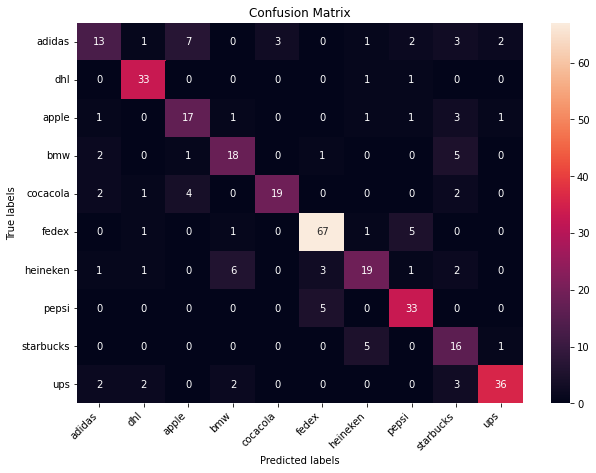

In [30]:
# Confusion Matrix
cm = confusion_matrix(y_val, lsvc_preds)

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix')
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names, rotation=0, ha='right')
plt.show()

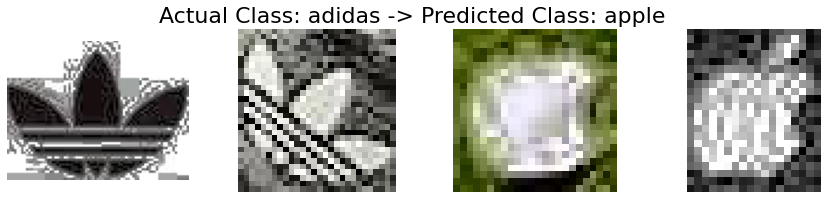

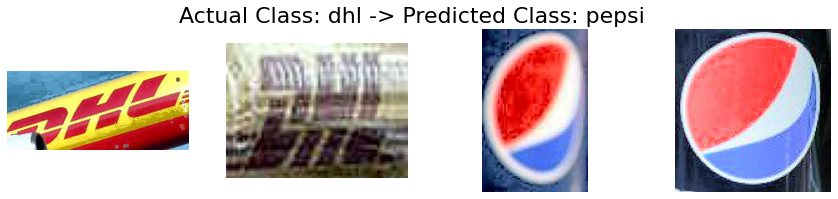

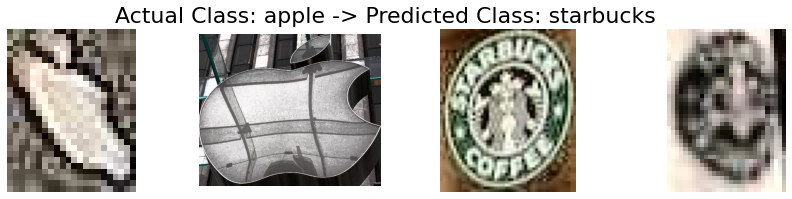

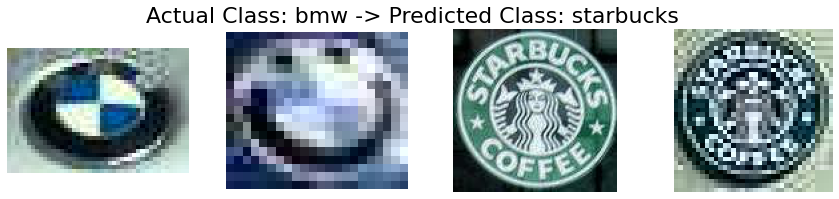

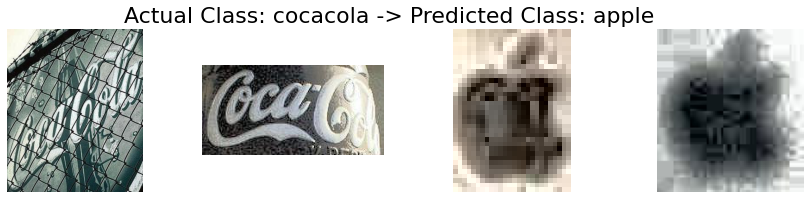

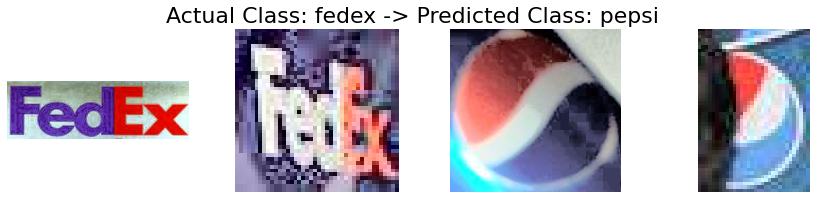

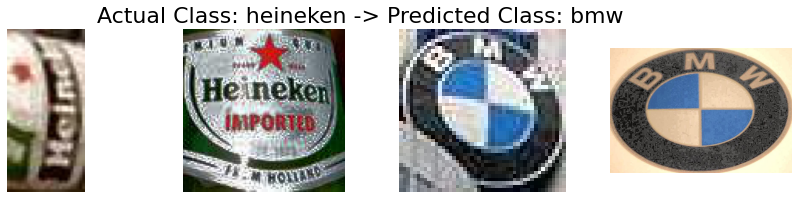

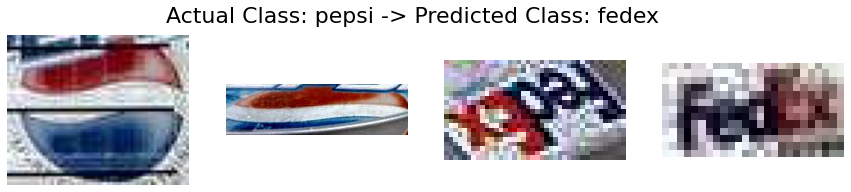

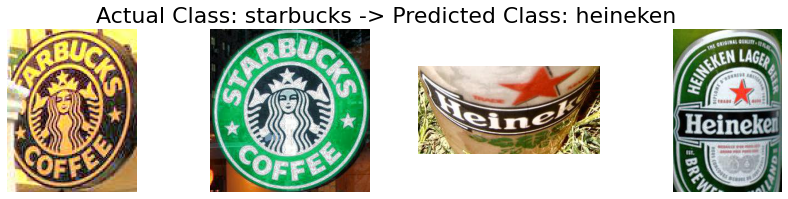

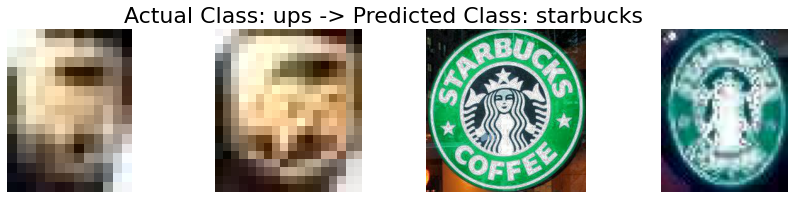

In [31]:
# Visualize Errors
for c in class_names:
  visualize_errors(val_df, c, cn_path)

## Model 1.2: K Nearest-Neighbors

In [32]:
# Fit model
neigh = KNeighborsClassifier(n_neighbors=16, weights='distance') #<--- tuned n value on val set
neigh.fit(X_train_scaled_ns, y_train)

# Generate preds
preds = neigh.predict(X_val_scaled_ns)
y_proba = neigh.predict_proba(X_val_scaled_ns)
val_df['pred'] = preds
val_df['pred_name'] = val_df["pred"].replace(class_map)

# Get accuracy
acc = accuracy_score(y_val, preds)
print(f"Accuracy: {acc:.2%}\n")

Accuracy: 66.67%



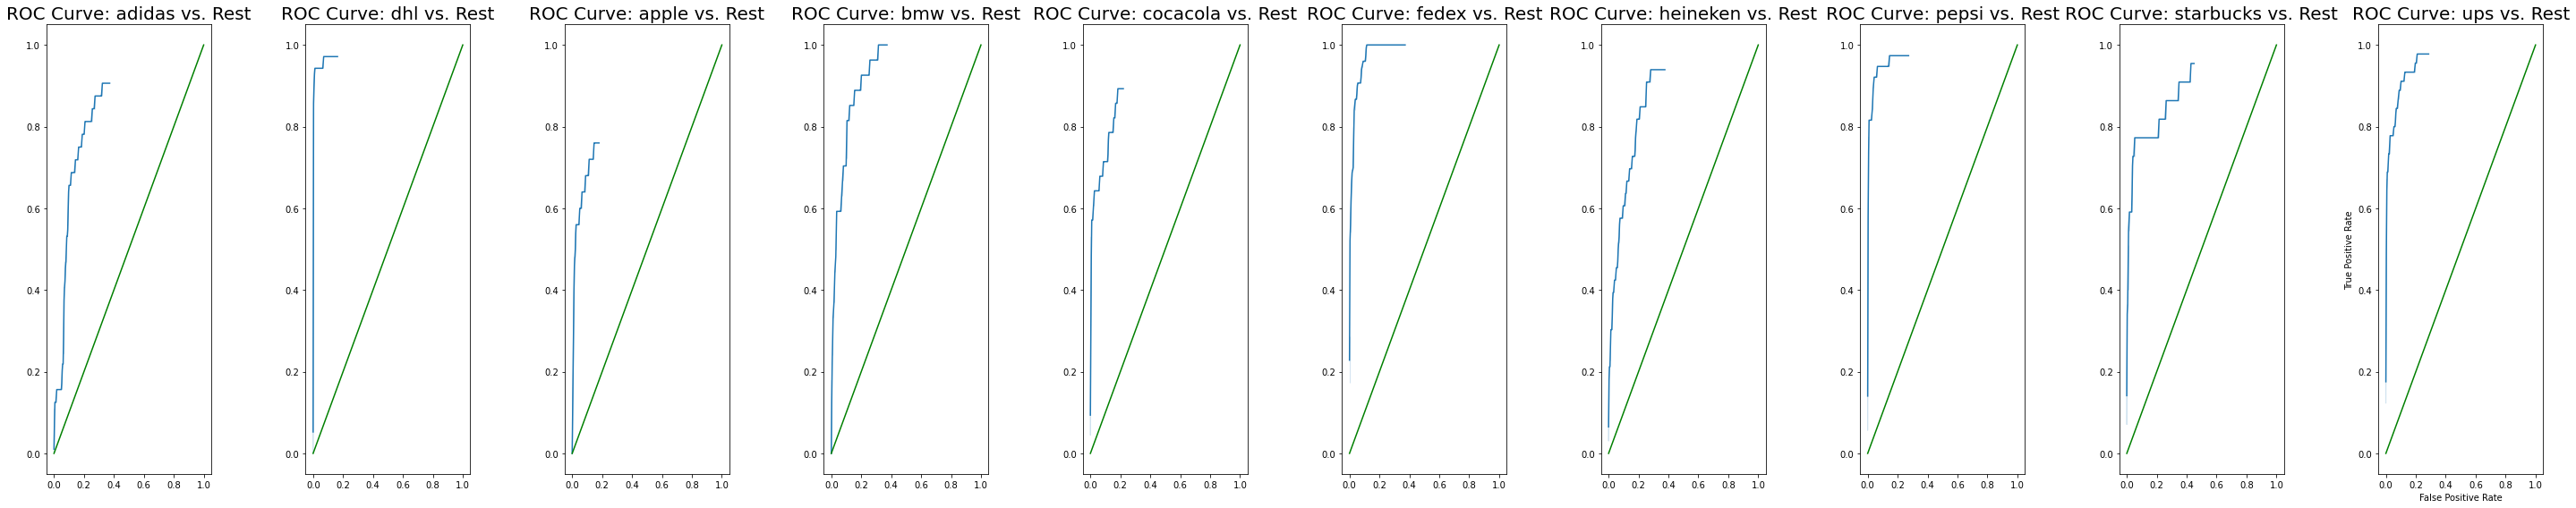

In [33]:
# # ROC Curves: One vs Rest for each class
roc_ovr_all(val_df, y_proba, class_map, figsize=(40, 8))

## Model 1.3: Log Regression

In [34]:
# define the multinomial logistic regression model
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
logreg.fit(X_train_scaled_ns, y_train)

# # tune params
# cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
# n_scores = cross_val_score(logreg, X_train, y_train['label'].values, scoring='accuracy', cv=cv, n_jobs=-1)
# # report the model performance
# print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

# Generate preds
lr_preds = logreg.predict(X_val_scaled_ns)
val_df['lr_pred'] = lr_preds
val_df['lr_pred_name'] = val_df["lr_pred"].replace(class_map)

# Get accuracy
acc = accuracy_score(y_val, lr_preds)
print(f"\nAccuracy: {acc:.2%}\n")


Accuracy: 73.33%



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [35]:
# # Classification Report
# # print(classification_report(y_val, lr_preds, target_names=class_names))

# # Confusion Matrix
# cm = confusion_matrix(y_val, lr_preds)

# fig, ax = plt.subplots(1, 1, figsize=(10, 7))
# sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
# ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
# ax.set_title('Confusion Matrix')
# ax.set_xticklabels(class_names, rotation=45, ha='right')
# ax.set_yticklabels(class_names, rotation=0, ha='right')
# plt.show()

# Section 2: All Features (Including SIFT)

## Model 2.1: Multinomial Logistic Regression

In [36]:
# define the multinomial logistic regression model
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
logreg.fit(X_train_scaled_all, y_train)

# Generate preds
lr_preds = logreg.predict(X_val_scaled_all)
val_df['lr_pred'] = lr_preds
val_df['lr_pred_name'] = val_df["lr_pred"].replace(class_map)

# Get accuracy
acc = accuracy_score(y_val, lr_preds)
print(f"Accuracy: {acc:.2%}\n")

Accuracy: 84.17%



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


## Model 2.2: SVM

In [37]:
# Instantiate linear SVC
lsvc = LinearSVC(penalty='l2', dual=False, multi_class = 'ovr', max_iter = 5000,
                 C = 0.22, class_weight='balanced')

# Fit the training histograms and predict with SVC on training data itself
lsvc.fit(X_train_scaled_all, y_train)

# Generate preds
lsvc_preds = lsvc.predict(X_val_scaled_all)
val_df['lsvc_pred'] = lsvc_preds
val_df['lsvc_pred_name'] = val_df["lsvc_pred"].replace(class_map)

# Get accuracy
acc = accuracy_score(y_val, lsvc_preds)
print(f"Accuracy: {acc:.2%}\n")

Accuracy: 78.89%



## Model 2.3: KNN

In [38]:
# Fit model
neigh = KNeighborsClassifier(n_neighbors=8, weights='distance') #<--- tuned n value on val set
neigh.fit(X_train_scaled_all, y_train)

# Generate preds
preds = neigh.predict(X_val_scaled_all)
y_proba = neigh.predict_proba(X_val_scaled_all)
val_df['pred'] = preds
val_df['pred_name'] = val_df["pred"].replace(class_map)

# Get accuracy
acc = accuracy_score(y_val, preds)
print(f"Accuracy: {acc:.2%}\n")

Accuracy: 51.39%



## Code Garage

In [ ]:
# # Tune Model

# #List Hyperparameters that we want to tune.
# leaf_size = list(range(20,50,2))
# n_neighbors = list(range(4,26,2))
# weights = ['uniform', 'distance']
# algos = ['auto', 'ball_tree', 'kd_tree', 'brute']
# p=[1,2]
# #Convert to dictionary
# hyperparameters = dict(leaf_size=leaf_size, 
#                        n_neighbors=n_neighbors, 
#                        p=p,
#                        weights=weights,
#                        algorithm=algos)
# #Create new KNN object
# knn_2 = KNeighborsClassifier()
# #Use GridSearch
# clf = GridSearchCV(knn_2, hyperparameters, cv=10)
# #Fit the model
# best_model = clf.fit(X_train_scaled, y_train)
# #Print The value of best Hyperparameters
# print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
# print('Best p:', best_model.best_estimator_.get_params()['p'])
# print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
# print('Best weights:', best_model.best_estimator_.get_params()['weights'])
# print('Best algorithm:', best_model.best_estimator_.get_params()['algorithm'])